# DeepLab Module

by @befreor 09.09.2019

"val_cocos.sh": CUDA_VISIBLE_DEVICES=0,1 python val.py --backbone resnet --lr 0.01 --workers 1 --epochs 40 --batch-size 2 --gpu-ids 0,1 --checkname deeplab-resnet --eval-interval 1 --dataset coco --resume=run/coco/deeplab-resnet/experiment_1/checkpoint.pth.tar

In [1]:
from PIL import Image, ImageFile, ImageFilter
from torchvision import transforms
import numpy as np
import torch
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from modeling.deeplab import *

ImageFile.LOAD_TRUNCATED_IMAGES = True

### Function of Data Preprocessing

In [2]:
class FixScaleCrop(object):
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, sample):
        img = sample
        w, h = img.size
        if w > h:
            oh = self.crop_size
            ow = int(1.0 * w * oh / h)
        else:
            ow = self.crop_size
            oh = int(1.0 * h * ow / w)
        img = img.resize((ow, oh), Image.BILINEAR)
        # center crop
        w, h = img.size
        x1 = int(round((w - self.crop_size) / 2.))
        y1 = int(round((h - self.crop_size) / 2.))
        img = img.crop((x1, y1, x1 + self.crop_size, y1 + self.crop_size))

        return img

In [3]:
class Normalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Args:
        mean (tuple): means for each channel.
        std (tuple): standard deviations for each channel.
    """
    def __init__(self, mean=(0., 0., 0.), std=(1., 1., 1.)):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        img = sample
        img = np.array(img).astype(np.float32)
        img /= 255.0
        img -= self.mean
        img /= self.std

        return img

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img = sample
        img = np.array(img).astype(np.float32).transpose((2, 0, 1))

        img = torch.from_numpy(img).float()

        return img

### Function of Masking Block with Different Color

In [5]:
def decode_seg_map_sequence(label_masks, dataset='pascal'):
    rgb_masks = []
    for label_mask in label_masks:
        rgb_mask = decode_segmap(label_mask, dataset)
        rgb_masks.append(rgb_mask)
    rgb_masks = torch.from_numpy(np.array(rgb_masks).transpose([0, 3, 1, 2]))
    return rgb_masks


def decode_segmap(label_mask, dataset, plot=False):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
          in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """
    if dataset == 'pascal' or dataset == 'coco':
        n_classes = 21
        label_colours = get_pascal_labels()
    elif dataset == 'cityscapes':
        n_classes = 19
        label_colours = get_cityscapes_labels()
    else:
        raise NotImplementedError

    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb
    
def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                       [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                       [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                       [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                       [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                       [0, 64, 128]])

### DeepLab Module

In [6]:
class DeeplabModule():
    def __init__(self):
        self.composed_transforms = transforms.Compose([
                                        FixScaleCrop(crop_size=1024),
                                        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                                        ToTensor()
                                    ])
        self.model = DeepLab(num_classes=8,
                        backbone="resnet",
                        output_stride=16,
                        sync_bn=None,
                        freeze_bn=False)
        
        self.display_func = (lambda x:\
                                decode_seg_map_sequence(torch.max(x, 1)[1].detach().cpu().numpy(),\
                                                        dataset="coco")[0])
        self.model_init()
        self.load_checkpoint()
        
    def model_init(self):
        self.model.eval()
        self.model.cuda()
        
    def load_checkpoint(self):
        checkpoint = torch.load("run/coco/deeplab-resnet/experiment_1/checkpoint.pth.tar")
        self.model.load_state_dict(checkpoint['state_dict'])
    
    def run(self, input_img_str):
        img = Image.open(input_img_str).convert('RGB')
        img = self.composed_transforms(img).cuda()
        
        output = self.model(img.view(1, 3, 1024, 1024))
        
        result = self.display_func(output)
        
        return result

### Sample Image

In [7]:
im = Image.open("sample_img.jpg").convert('RGB')

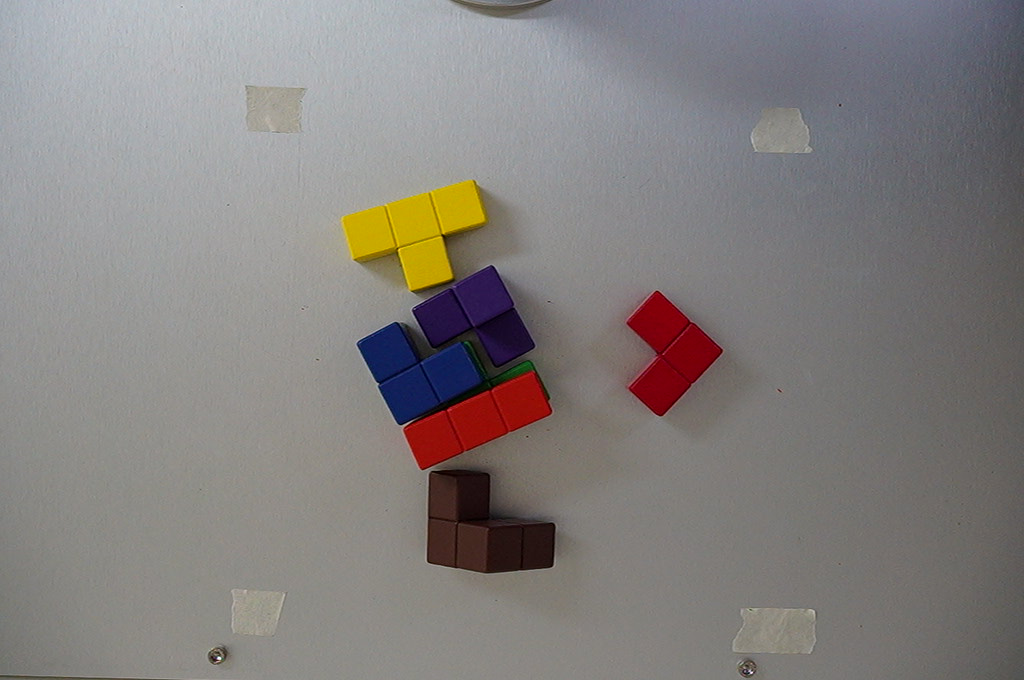

In [8]:
im

### Example Code

In [9]:
deeplab = DeeplabModule()

In [10]:
out = deeplab.run("sample_img.jpg")

In [11]:
out

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

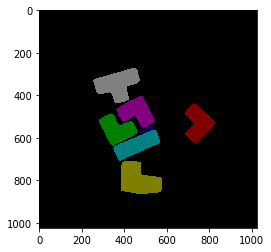

In [12]:
plt.imshow(np.transpose(out, (1,2,0)))